Notebook to analyse the relation of the presence or not of SBP adoption in each municipality in each year with the various features).

1st step of the double hurdle model.

# Content
* Data ingestion
* Data first exploration
* Features analysis
    * Variance analysis
    * Correlation - Spearman rho and correlation matrices
        * All years
        * Restricted to PCF years (and comparison with all years)
        * Low correlations
        * Census features combinations
* Create transformer based on results of combination and correlations
* Multicollinearity analysis (VIF)
    * With census features combined and not

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
path_to_final_dataset = "Municipalities final dataset for analysis.csv"

In [4]:
# How to display floats
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=6)

# Data ingestion

In [5]:
dataset_original = pd.read_csv(path_to_final_dataset, index_col=['Municipality', 'Year'])

### Transform the label into 1/0 for adoption yes/no

In [6]:
dataset_original['adoption_in_year'] = dataset_original['adoption_in_year'].apply(lambda x: 1 if x > 0.0000001 else 0)

In [7]:
dataset = dataset_original.reset_index(drop=True)

In [8]:
dataset.head(2)

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
0,0,0.000,0.000,0.398,0.243,0.508,2.160,0.608,13.100,0.710,...,13.306,1029.408,271.403,49.111,10.764,17.127,2.340,17.505,5.274,0.000
1,1,0.000,0.001,0.426,0.264,0.569,2.220,0.613,13.600,0.710,...,13.306,1029.408,271.403,49.111,10.764,17.127,2.340,17.505,5.274,0.000


In [9]:
dataset.columns

Index(['adoption_in_year', 'tot_cumul_adoption_pr_y_munic',
       'tot_cumul_adoption_pr_y_port', 'pastures_area_var',
       'pastures_area_munic', 'pastures_area_mean', 'agric_area_mean',
       'agric_area_owned', 'tract_100ha', 'lu_cattle', 'lu_per_agric_area',
       'farmers_female', 'farmers_over65', 'educ_none', 'educ_second_super',
       'agric_time_full', 'inc_excl_agric', 'inc_mainly_ext',
       'work_unit_100ha', 'av_d_mean_t_pr_y_munic',
       'days_mean_t_over_20_pr_y_munic', 'days_mean_t_over_25_pr_y_munic',
       'av_d_max_t_pr_y_munic', 'days_max_t_over_30_pr_y_munic',
       'av_d_min_t_pr_y_munic', 'days_min_t_under_0_pr_y_munic',
       'av_prec_sum_pr_y_munic', 'days_no_prec_pr_y_munic',
       'cons_days_no_prec_pr_y_munic', 'av_d_mean_t_average_munic',
       'days_mean_t_over_20_average_munic',
       'days_mean_t_over_25_average_munic', 'av_d_max_t_average_munic',
       'days_max_t_over_30_average_munic', 'av_d_min_t_average_munic',
       'days_min_t_und

## Organise features by categorical/numerical and by topic

In [10]:
label = ['adoption_in_year']

In [11]:
features_list = [col for col in dataset.columns if col != 'adoption_in_year']
features = pd.DataFrame(index=dataset.columns, columns=['num/cat', 'topic'])

In [12]:
adoption_features = [feat for feat in features.index if 'adoption' in feat and feat not in label]
features.loc[adoption_features, :] = ['num', 'SBP_adoption']

In [13]:
climate_features = [feat for feat in features.index if '_t_' in feat or '_prec_' in feat]
features.loc[climate_features, :] = ['num', 'climate']

In [14]:
soil_features = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features.loc[soil_features, :] = ['num', 'soil']

In [15]:
economic_features = ['sbp_payment']
features.loc[economic_features, :] = ['num', 'economic']

In [16]:
features_not_census = adoption_features + climate_features + soil_features + economic_features
census_features = [feat for feat in features_list if feat not in features_not_census]
features.loc[census_features, :] = ['num', 'census']

# First exploration

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   adoption_in_year                   4698 non-null   int64  
 1   tot_cumul_adoption_pr_y_munic      4698 non-null   float64
 2   tot_cumul_adoption_pr_y_port       4698 non-null   float64
 3   pastures_area_var                  4698 non-null   float64
 4   pastures_area_munic                4698 non-null   float64
 5   pastures_area_mean                 4698 non-null   float64
 6   agric_area_mean                    4698 non-null   float64
 7   agric_area_owned                   4698 non-null   float64
 8   tract_100ha                        4698 non-null   float64
 9   lu_cattle                          4698 non-null   float64
 10  lu_per_agric_area                  4698 non-null   float64
 11  farmers_female                     4698 non-null   float

In [19]:
dataset.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,...,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000,4698.000
mean,0.525,0.018,0.027,1.096,0.262,7.140,15.996,0.765,12.531,0.377,...,9.259,811.377,281.057,59.675,26.430,14.286,1.700,17.495,5.780,32.553
std,0.499,0.058,0.023,1.347,0.240,15.676,27.365,0.156,11.023,0.260,...,10.851,240.765,14.357,13.014,29.271,2.230,0.453,7.205,0.542,58.780
min,0.000,0.000,0.000,0.008,0.001,0.001,0.310,0.135,0.300,0.000,...,0.000,482.106,235.396,29.521,0.859,10.109,0.565,1.365,4.923,0.000
25%,0.000,0.000,0.007,0.772,0.061,0.164,2.640,0.665,3.862,0.129,...,0.389,607.929,275.071,50.986,7.652,12.299,1.396,12.152,5.292,0.000
50%,1.000,0.002,0.023,0.973,0.175,0.883,4.800,0.783,8.900,0.362,...,4.861,783.824,281.458,57.142,16.433,14.535,1.600,17.342,5.699,0.000
75%,1.000,0.019,0.045,1.072,0.421,4.401,11.295,0.898,19.450,0.596,...,14.396,916.092,290.632,68.167,32.744,16.213,2.095,22.405,6.154,0.000
max,1.000,0.905,0.070,35.667,0.956,135.392,173.500,1.000,69.940,1.000,...,46.175,1573.570,307.500,89.742,174.955,19.020,3.443,41.665,7.267,153.260


## Explore label

In [20]:
dataset[label].value_counts()

adoption_in_year
1                   2466
0                   2232
dtype: int64

array([[<AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_munic'}>,
        <AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_port'}>]],
      dtype=object)

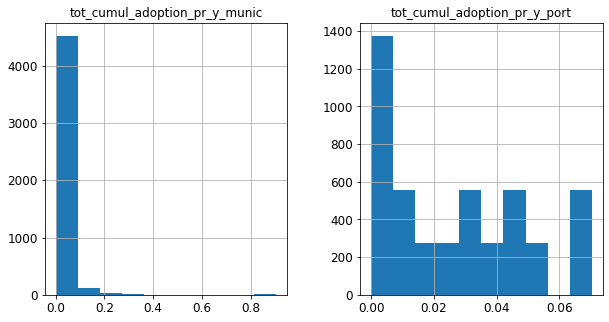

In [25]:
adoption_features = features.loc[features['topic'] == 'SBP_adoption'].index.tolist()
dataset[adoption_features].hist(figsize=(10, 5))

array([[<AxesSubplot:title={'center':'pastures_area_var'}>,
        <AxesSubplot:title={'center':'pastures_area_munic'}>,
        <AxesSubplot:title={'center':'pastures_area_mean'}>,
        <AxesSubplot:title={'center':'agric_area_mean'}>],
       [<AxesSubplot:title={'center':'agric_area_owned'}>,
        <AxesSubplot:title={'center':'tract_100ha'}>,
        <AxesSubplot:title={'center':'lu_cattle'}>,
        <AxesSubplot:title={'center':'lu_per_agric_area'}>],
       [<AxesSubplot:title={'center':'farmers_female'}>,
        <AxesSubplot:title={'center':'farmers_over65'}>,
        <AxesSubplot:title={'center':'educ_none'}>,
        <AxesSubplot:title={'center':'educ_second_super'}>],
       [<AxesSubplot:title={'center':'agric_time_full'}>,
        <AxesSubplot:title={'center':'inc_excl_agric'}>,
        <AxesSubplot:title={'center':'inc_mainly_ext'}>,
        <AxesSubplot:title={'center':'work_unit_100ha'}>]], dtype=object)

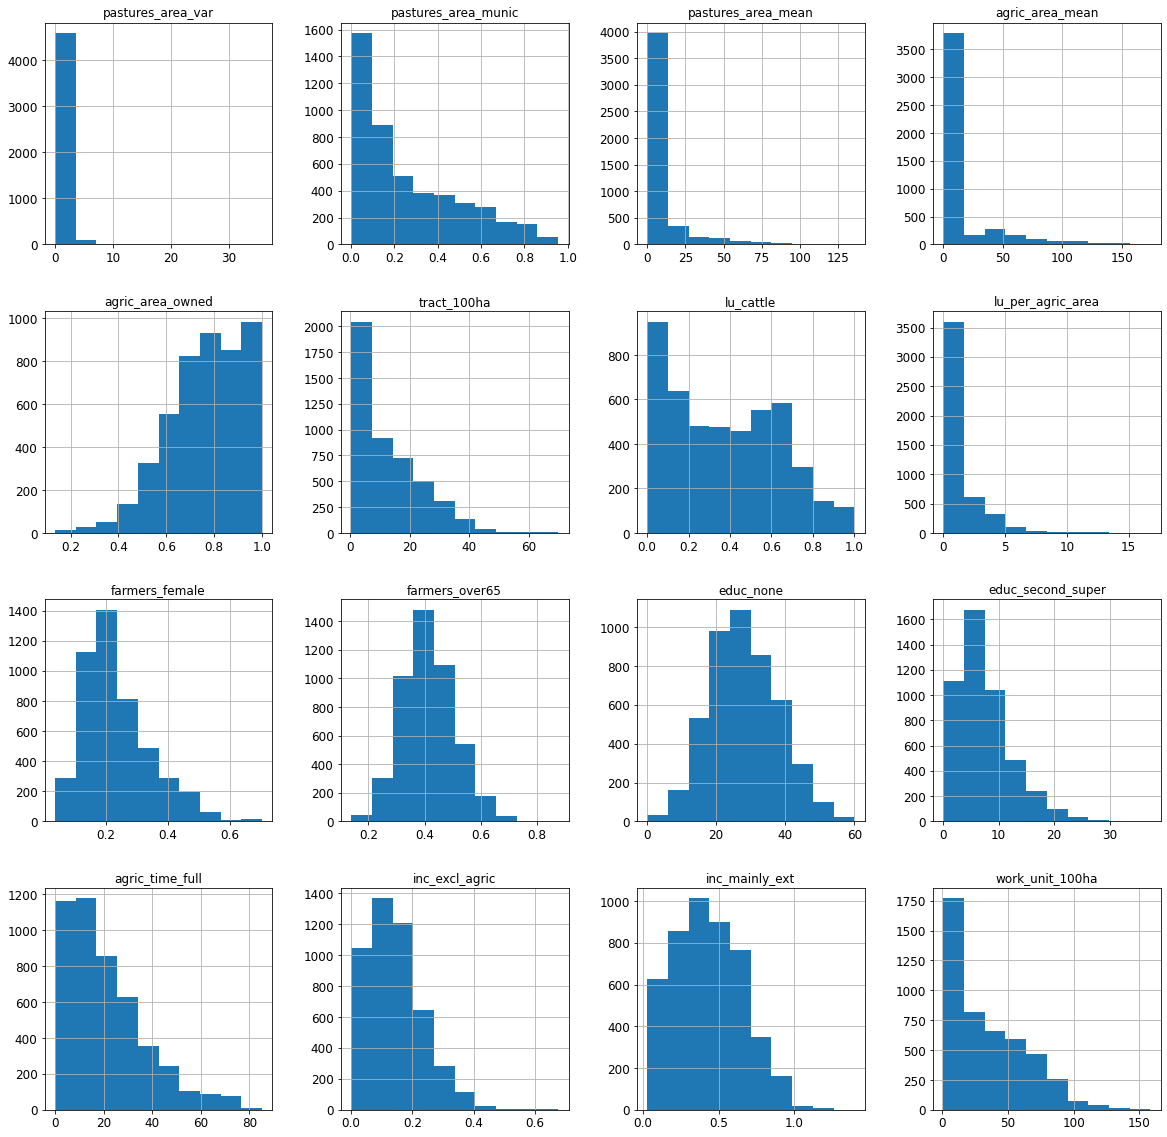

In [26]:
census_features = features.loc[(features['topic'] == 'census')].index.tolist()
dataset[census_features].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'av_d_mean_t_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_20_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_25_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_max_t_pr_y_munic'}>],
       [<AxesSubplot:title={'center':'days_max_t_over_30_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_min_t_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_min_t_under_0_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_prec_sum_pr_y_munic'}>],
       [<AxesSubplot:title={'center':'days_no_prec_pr_y_munic'}>,
        <AxesSubplot:title={'center':'cons_days_no_prec_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_mean_t_average_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_20_average_munic'}>],
       [<AxesSubplot:title={'center':'days_mean_t_over_25_average_munic'}>,
        <AxesSubplot:title={'center':'av_d_max_t_average_munic'}>,
        <AxesSubplot:titl

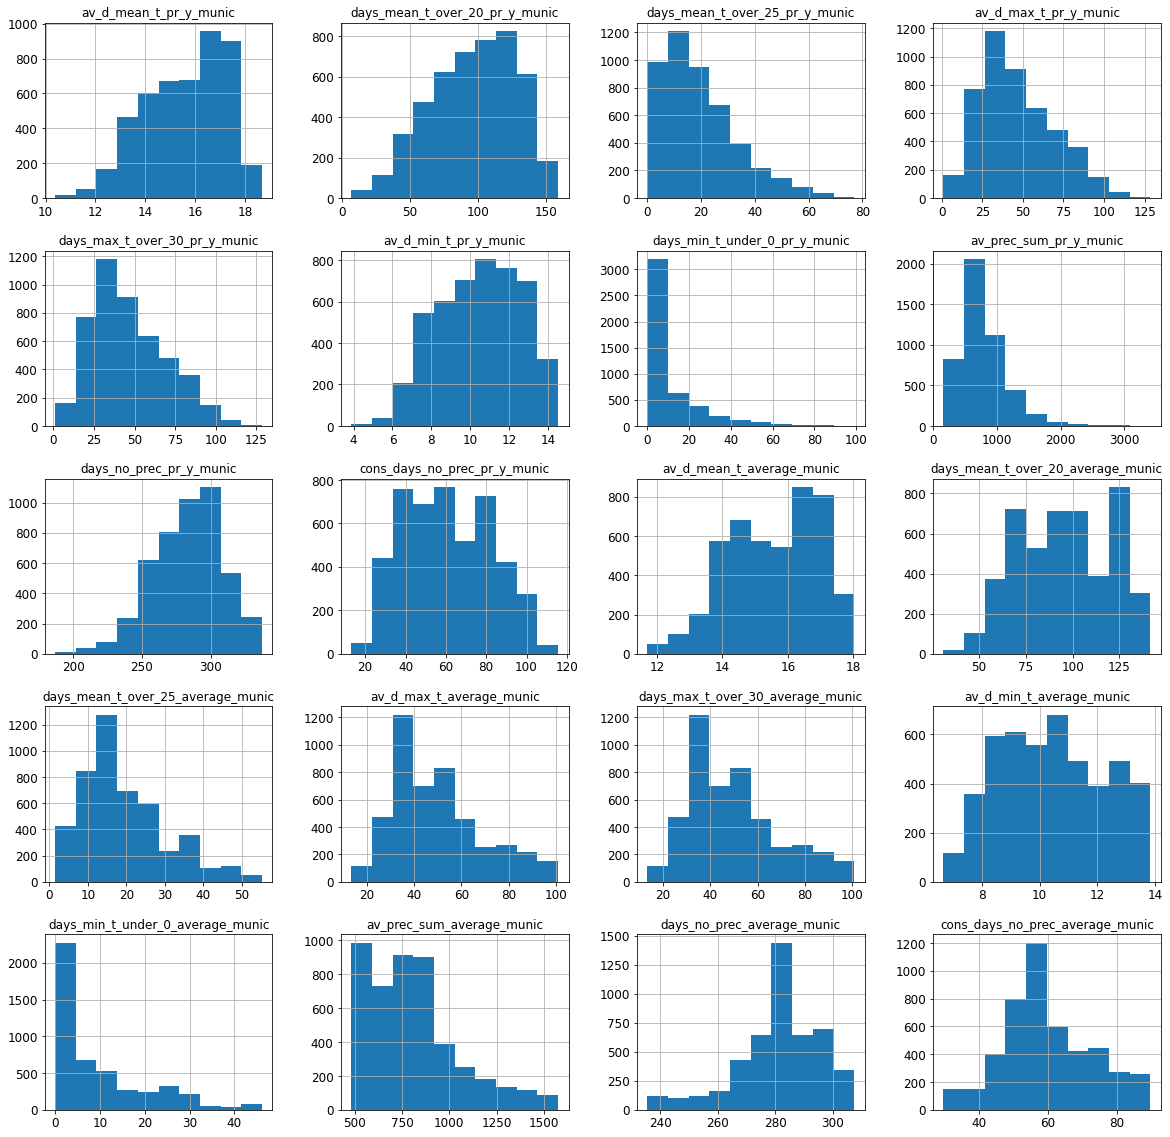

In [27]:
climate_features = features.loc[features['topic'] == 'climate'].index.tolist()
dataset[climate_features].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'CaCO3_mean_munic'}>,
        <AxesSubplot:title={'center':'CN_mean_munic'}>],
       [<AxesSubplot:title={'center':'N_mean_munic'}>,
        <AxesSubplot:title={'center':'P_mean_munic'}>],
       [<AxesSubplot:title={'center':'pH_mean_munic'}>, <AxesSubplot:>]],
      dtype=object)

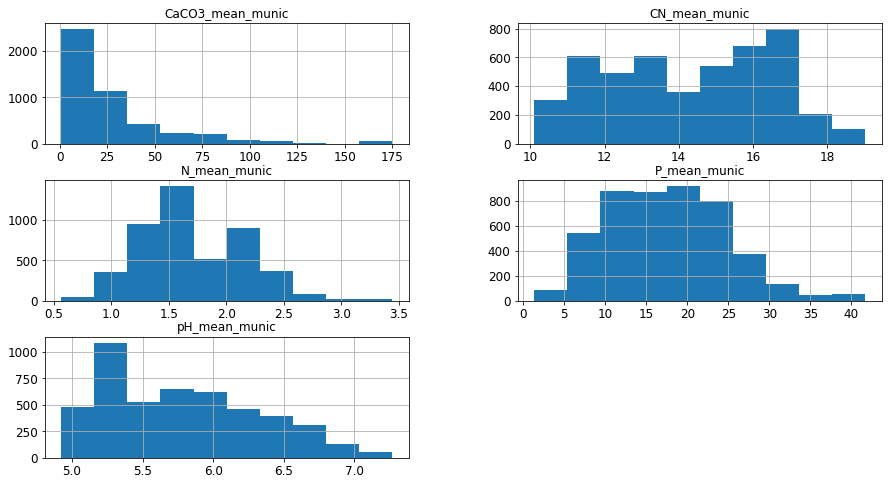

In [28]:
soil_features = features.loc[features['topic'] == 'soil'].index.tolist()
dataset[soil_features].hist(figsize=(15, 8))

In [29]:
features_num = features.loc[features['num/cat'] == 'num'].index.tolist()

# Features analysis

## Correlation analysis with label - Spearman rho and matrices

### All years

In [30]:
from scipy.stats import spearmanr

def get_spearmanr_results(features):
    results = pd.DataFrame(index=features, columns=['spearman r'])

    for (columnName, columnData) in dataset[features].iteritems():
        coef, p = spearmanr(columnData, dataset['adoption_in_year'])
        results.loc[columnName] = coef
    return results

In [31]:
spearman_results = get_spearmanr_results(features_num)

In [32]:
spearman_results.loc[adoption_features, :].sort_values('spearman r', ascending=False)

,spearman r
tot_cumul_adoption_pr_y_munic,0.492
tot_cumul_adoption_pr_y_port,-0.221


In [33]:
spearman_results.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r
pastures_area_mean,0.187
agric_area_mean,0.152
pastures_area_munic,0.148
educ_none,0.141
inc_excl_agric,0.117
lu_cattle,0.096
educ_second_super,-0.010
agric_area_owned,-0.059
agric_time_full,-0.060
lu_per_agric_area,-0.067


In [34]:
spearman_results.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r
cons_days_no_prec_average_munic,0.287
days_max_t_over_30_average_munic,0.246
av_d_max_t_average_munic,0.246
days_mean_t_over_25_average_munic,0.234
days_mean_t_over_20_average_munic,0.224
days_no_prec_average_munic,0.212
av_d_mean_t_average_munic,0.203
cons_days_no_prec_pr_y_munic,0.197
days_max_t_over_30_pr_y_munic,0.142
av_d_max_t_pr_y_munic,0.142


In [35]:
spearman_results.loc[soil_features, :].sort_values('spearman r', ascending=False)

,spearman r
pH_mean_munic,0.060
N_mean_munic,-0.020
CaCO3_mean_munic,-0.074
CN_mean_munic,-0.110
P_mean_munic,-0.155


In [36]:
economic_features = features.loc[(features['topic'] == 'economic')].index.tolist()
spearman_results.loc[economic_features, :].sort_values('spearman r', ascending=False)

,spearman r
sbp_payment,-0.363


This weird negative correlation can be explained because the disaggregation of the adoption pre-PCF caused more municipalities than in reality to adopt in the years prior to 2008, when no payments were provided.

#### Corrrelation matrix to spot also relation among the features

In [37]:
corr_matrix_sp = dataset.corr(method='spearman').round(decimals=2)

In [38]:
def plot_correlation_heatmap(matrix, size=(20, 20)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=range(len(matrix.index)), ticklabels=matrix.index)
    plt.xticks(rotation=90)
    ax.yaxis.set(ticks=range(len(matrix.columns)), ticklabels=matrix.columns)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            ax.text(j, i, matrix.iloc[i, j], ha='center', va='center',
                    color='r')
    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()

In [39]:
climate_features_average = [feat for feat in climate_features if 'average' in feat]

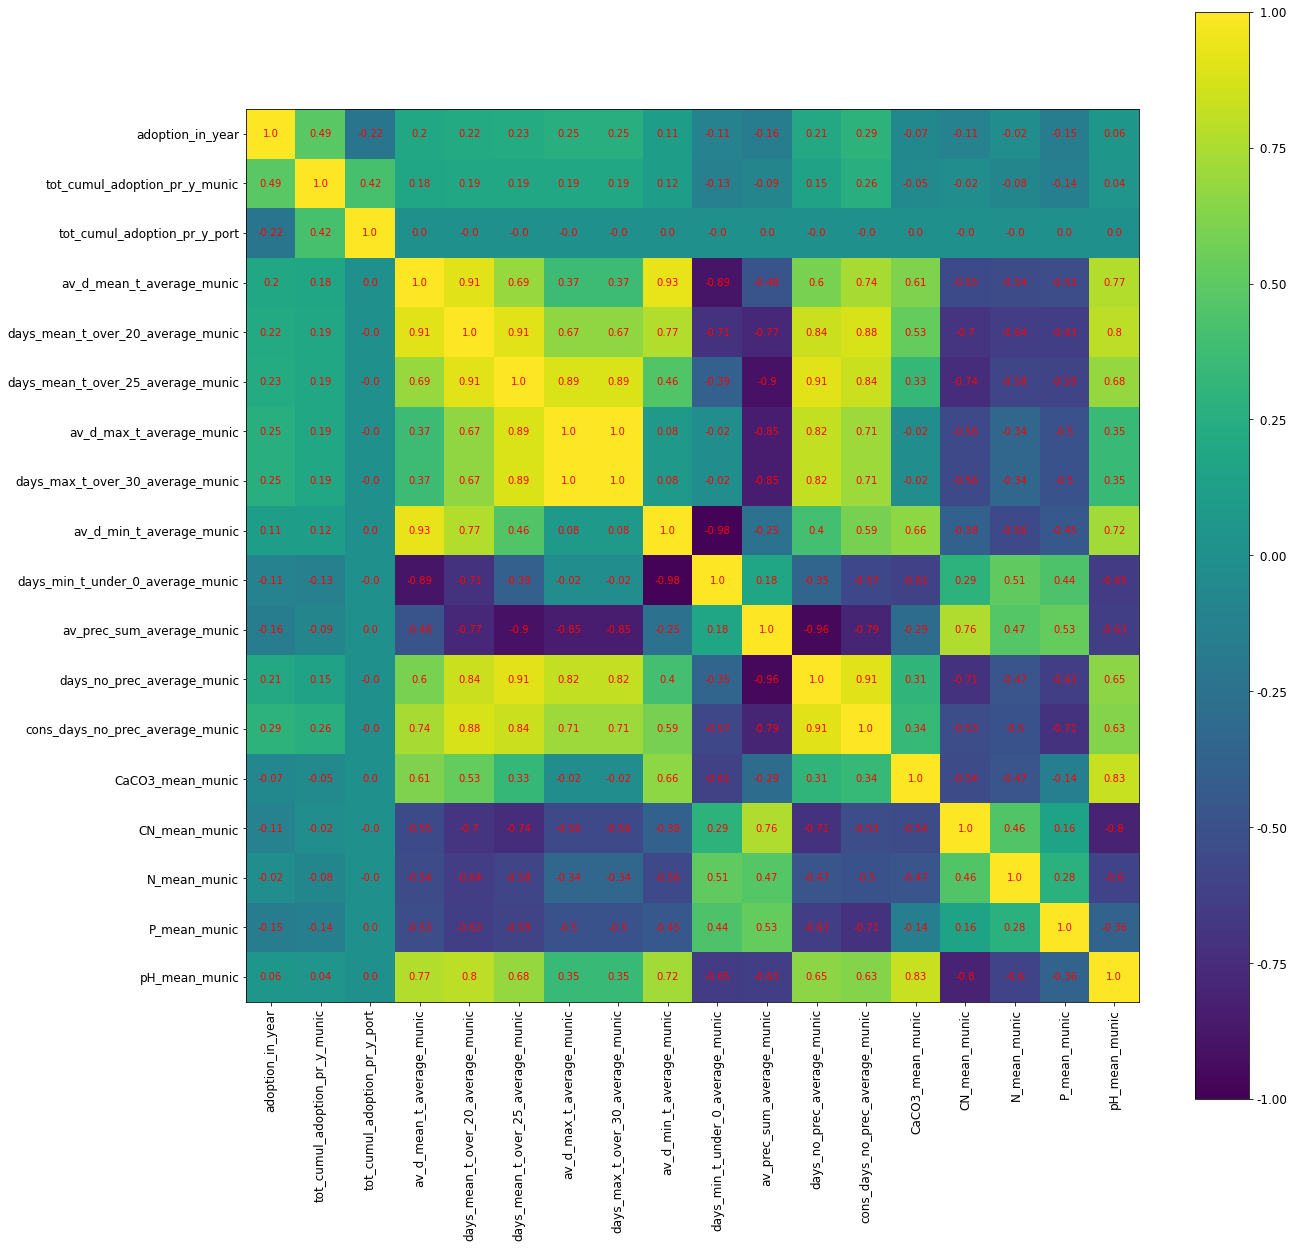

In [40]:
features_to_show = label + adoption_features + climate_features_average + soil_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Census features

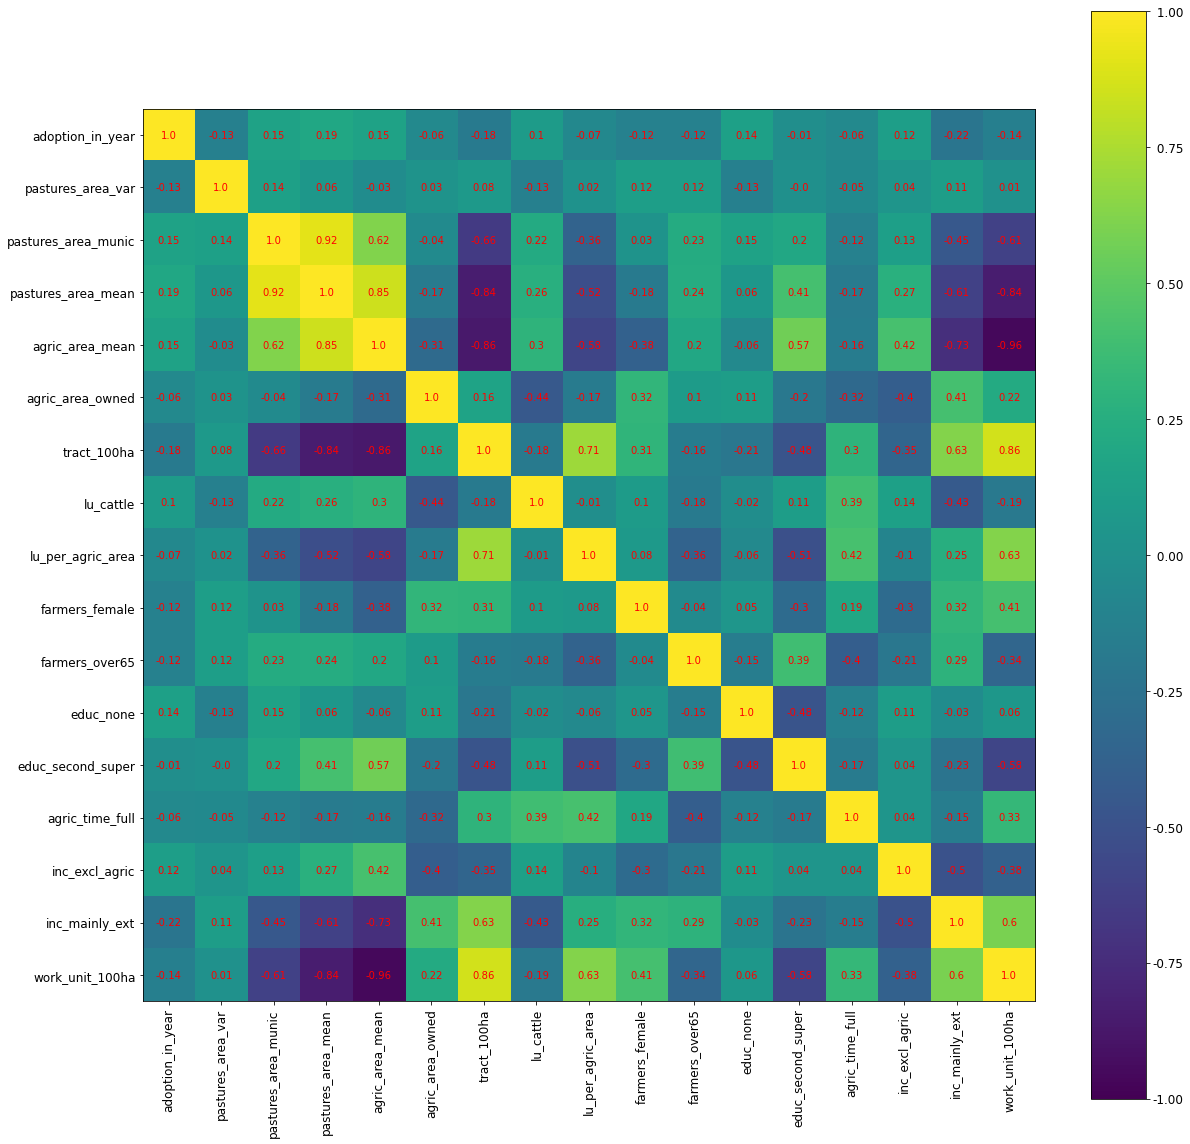

In [44]:
features_to_show = label + census_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

Environmental features

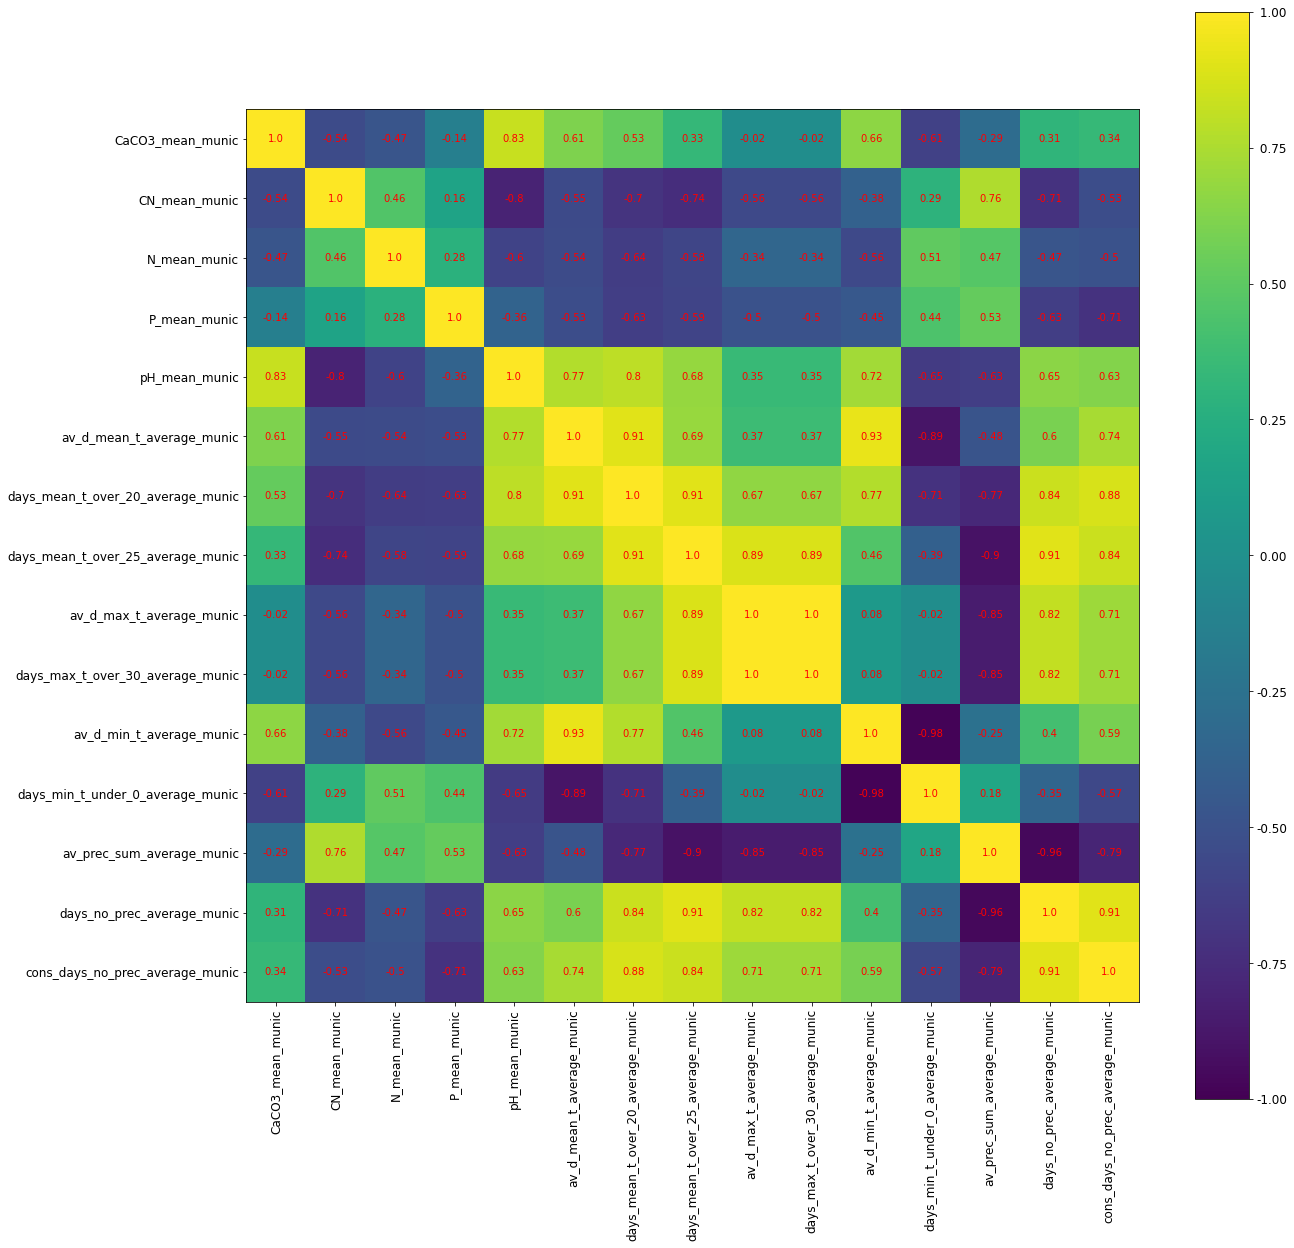

In [45]:
features_to_show = soil_features + climate_features_average
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

In [46]:
features_cat = features.loc[features['num/cat'] == 'cat'].index.tolist()

### Restricted to PCF years (and comparison with all years)

Analysis to check correlations only during the years of the PCF projects, since these are the years for which we have reliable labels.

In [47]:
dataset_PCF = dataset_original.loc[(slice(None), [2009, 2010, 2011, 2012]), :]

**Note:** the inclusion of 2009 makes the correlation regarding adoption in the previous year nor right, since it takes into consideration values from 2008 that are disaggregated.

If 2009 not considered, this correlation would be much higher! At 0.79. But it also makes sense also just because there are a lot of 0s that remains as such. In fact, if we look at the results for the regression the correlation is much lower.

The historical adoption has the same behaviour.

In [48]:
dataset_PCF = dataset_PCF.reset_index(drop=True)

In [49]:
dataset_PCF.shape

(1108, 45)

In [50]:
dataset_PCF.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,...,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000,1108.000
mean,0.194,0.040,0.060,1.011,0.308,9.399,17.501,0.764,14.863,0.393,...,9.245,811.769,281.035,59.656,26.540,14.286,1.700,17.508,5.781,138.027
std,0.396,0.090,0.008,0.105,0.267,19.928,29.219,0.166,12.898,0.279,...,10.847,240.861,14.359,13.012,29.367,2.229,0.453,7.223,0.543,9.392
min,0.000,0.000,0.048,0.800,0.003,0.006,1.160,0.135,0.300,0.000,...,0.000,482.106,235.396,29.521,0.859,10.109,0.565,1.365,4.923,128.790
25%,0.000,0.000,0.054,0.980,0.084,0.248,2.857,0.660,4.665,0.117,...,0.389,607.929,275.071,50.986,7.652,12.299,1.396,12.152,5.292,131.272
50%,0.000,0.021,0.060,1.000,0.206,1.058,5.360,0.786,10.410,0.382,...,4.861,783.824,281.458,57.142,16.433,14.535,1.600,17.342,5.699,135.030
75%,0.000,0.041,0.066,1.033,0.529,6.202,12.192,0.907,23.558,0.631,...,14.396,916.092,290.632,68.167,32.744,16.213,2.095,22.405,6.154,141.785
max,1.000,0.905,0.070,3.283,0.956,135.392,157.030,1.000,69.940,1.000,...,46.175,1573.570,307.500,89.742,174.955,19.020,3.443,41.665,7.267,153.260


In [51]:
from scipy.stats import spearmanr

spearman_results_PCF = pd.DataFrame(index=features_num, columns=['spearman r only PCF'])

for (columnName, columnData) in dataset_PCF[features_num].iteritems():
    coef, p = spearmanr(columnData, dataset_PCF['adoption_in_year'])
    spearman_results_PCF.loc[columnName] = coef

In [53]:
# Merge with spearman rho results with all to compare
spearman_results_both = pd.concat([spearman_results_PCF, spearman_results], axis=1)

In [54]:
spearman_results_both.loc[adoption_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
tot_cumul_adoption_pr_y_munic,0.427,0.492
tot_cumul_adoption_pr_y_port,0.003,-0.221


In [55]:
spearman_results_both.loc[census_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
agric_area_mean,0.618,0.152
pastures_area_mean,0.608,0.187
pastures_area_munic,0.479,0.148
educ_second_super,0.451,-0.010
lu_cattle,0.343,0.096
inc_excl_agric,0.211,0.117
pastures_area_var,0.059,-0.133
farmers_over65,0.035,-0.119
educ_none,-0.071,0.141
agric_time_full,-0.276,-0.060


In [56]:
spearman_results_both.loc[climate_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
days_mean_t_over_25_average_munic,0.586,0.234
days_max_t_over_30_average_munic,0.581,0.246
av_d_max_t_average_munic,0.581,0.246
days_no_prec_average_munic,0.513,0.212
days_mean_t_over_20_average_munic,0.505,0.224
cons_days_no_prec_average_munic,0.498,0.287
av_d_max_t_pr_y_munic,0.494,0.142
days_max_t_over_30_pr_y_munic,0.494,0.142
days_mean_t_over_25_pr_y_munic,0.440,0.113
days_mean_t_over_20_pr_y_munic,0.424,0.081


In [57]:
spearman_results_both.loc[soil_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pH_mean_munic,0.316,0.060
CaCO3_mean_munic,0.004,-0.074
N_mean_munic,-0.215,-0.020
P_mean_munic,-0.311,-0.155
CN_mean_munic,-0.490,-0.110


In [58]:
spearman_results_both.loc[economic_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
sbp_payment,0.011,-0.363


Here it makes sense that it's almost 0, since the payments are not changing much during the project

# Multicollinearity analysis (VIF)

**NOTE:** 
* dataset refers to the dataset with all features
* dataset_attr_red refers to the dataset with attributes reduced based on correlation coefficients

Based on dataset including all years (unless not clear)

In [60]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [61]:
def calculate_vif(dataset):
    features = "+".join([feat for feat in dataset.columns if feat != "adoption_in_year"])
    y, X = dmatrices('adoption_in_year ~' + features, dataset, return_type='dataframe')
    with pd.option_context('mode.use_inf_as_null', True):
        X = X.dropna()

    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.set_index("features", inplace=True)
    return vif

In [62]:
vif = calculate_vif(dataset)

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [63]:
vif.sort_values('VIF', ascending=False).head(10)

,VIF
features,
av_d_max_t_pr_y_munic,inf
days_max_t_over_30_pr_y_munic,inf
days_max_t_over_30_average_munic,inf
av_d_max_t_average_munic,inf
Intercept,107031.796
days_mean_t_over_20_average_munic,332.007
av_d_mean_t_average_munic,326.258
av_d_min_t_average_munic,228.519
days_no_prec_average_munic,170.445


## Custom transformers to reduce features and multicollinearity

Create a different transformer for each topic of features, to not have any VIF above 10

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

In [65]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

In [66]:
corr_matrix = dataset.corr(method='spearman').round(decimals=2)

In [67]:
sp_r_both = get_spearman_both('all', dataset, dataset_PCF)

### Census features

In [68]:
census_features_indic = pd.concat(
    [spearman_results_both.loc[census_features, :], vif.loc[census_features]], axis=1, join='inner'
)

In [69]:
census_features_indic.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r,VIF
pastures_area_mean,0.608,0.187,9.344
agric_area_mean,0.618,0.152,10.911
pastures_area_munic,0.479,0.148,5.251
educ_none,-0.071,0.141,3.639
inc_excl_agric,0.211,0.117,2.285
lu_cattle,0.343,0.096,2.600
educ_second_super,0.451,-0.010,3.515
agric_area_owned,-0.278,-0.059,2.498
agric_time_full,-0.276,-0.060,2.767
lu_per_agric_area,-0.280,-0.067,1.832


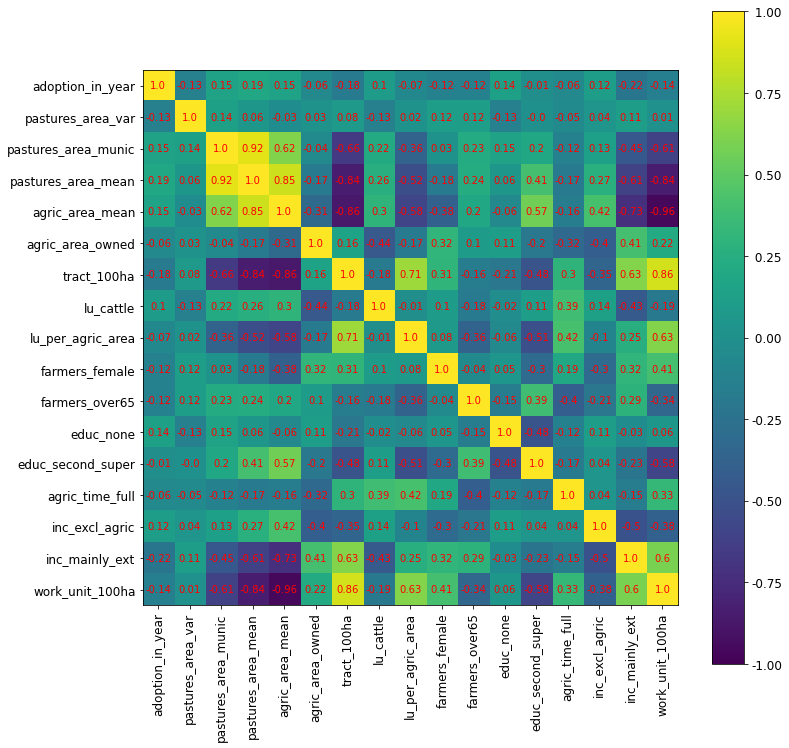

In [70]:
plot_correlation_heatmap(corr_matrix.loc[label + census_features, label + census_features], size=(12, 12))

In [101]:
class TransformCensusFeatures(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Features removed (thus not added): pastures_area_munic, agric_area_mean, farmers_female, inc_excl_agric,
        # tract_100ha
        
        feats_to_keep = ['pastures_area_var', 'pastures_area_mean', 'educ_second_super', 'farmers_over65', 
                        'inc_mainly_ext', 'educ_none', 'work_unit_100ha', 'agric_area_owned', 'lu_per_agric_area']
        XX = X[feats_to_keep]    

        return XX

### Adoption features

In [72]:
vif.loc[adoption_features]

,VIF
features,
tot_cumul_adoption_pr_y_munic,1.153
tot_cumul_adoption_pr_y_port,7.164


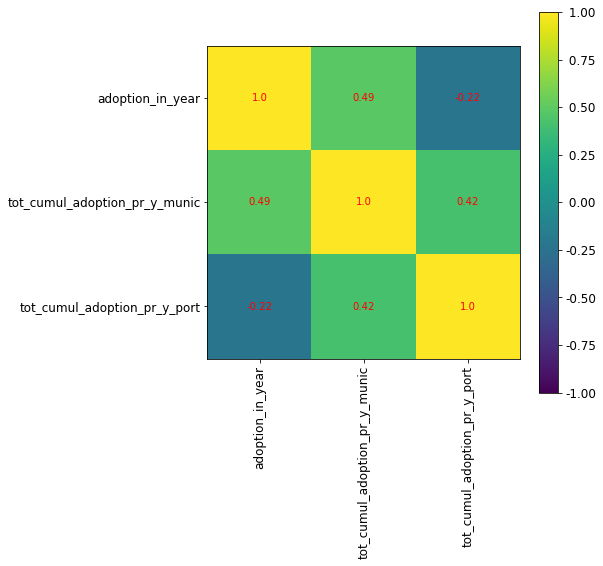

In [73]:
plot_correlation_heatmap(corr_matrix.loc[label + adoption_features, label + adoption_features], size=(7, 7))

In [74]:
class TransformAdoptionFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats_to_keep = ["tot_cumul_adoption_pr_y_munic", "tot_cumul_adoption_pr_y_port"]
        
        return X[feats_to_keep]

### Soil and climate features

In [75]:
env_features = soil_features + climate_features

In [76]:
prec_features = [feat for feat in climate_features if '_prec' in feat]

In [77]:
sp_r_both.loc[prec_features].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
cons_days_no_prec_average_munic,0.498,0.287
days_no_prec_average_munic,0.513,0.212
cons_days_no_prec_pr_y_munic,0.385,0.197
days_no_prec_pr_y_munic,0.237,0.137
av_prec_sum_pr_y_munic,-0.280,-0.130
av_prec_sum_average_munic,-0.480,-0.156


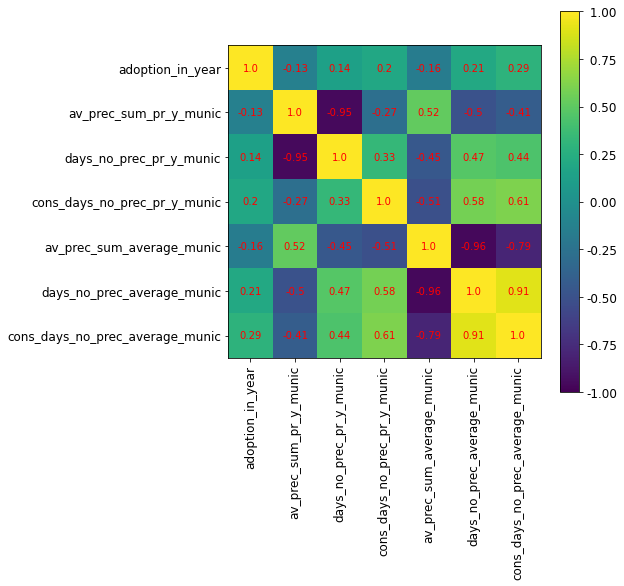

In [78]:
plot_correlation_heatmap(corr_matrix.loc[label + prec_features, label + prec_features], size=(7, 7))

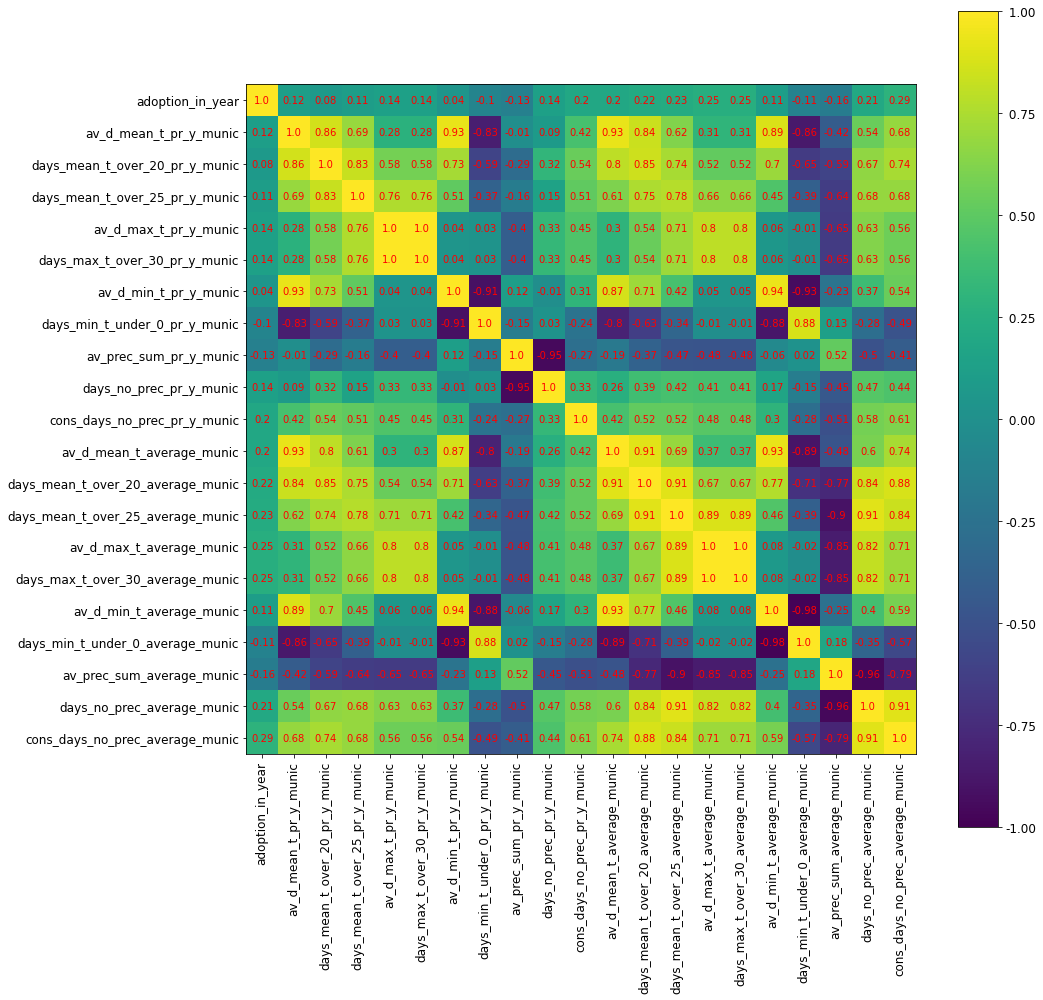

In [79]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features, label + climate_features], size=(15, 15))

In [80]:
max_t_feats = [feat for feat in climate_features if '_max_t' in feat]
spearman_results_both.loc[max_t_feats ]

,spearman r only PCF,spearman r
av_d_max_t_pr_y_munic,0.494,0.142
days_max_t_over_30_pr_y_munic,0.494,0.142
av_d_max_t_average_munic,0.581,0.246
days_max_t_over_30_average_munic,0.581,0.246


In [81]:
class TransformClimateFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        climate_features = X.columns
        
        # All previous years ones excluded since the averages are more correlated!
        
        # Min temp: excluded all since high correlation with av_d_mean_t and
        # low with the target variable
        # Max temp: can keep only one of the two since perfectly correlated,
        # so exluded both days_max_t_over_30
        # Mean temp: excluded days_mean_t_over_20/25 since only one of these
        # kept and av_d_mean_t less correlated with max_t 
        # Prec: exclude both av_prec_sum_pr_y (too correlated with max_t) and
        # days_no
        
        # Definition of the ones to keep.
        feats_mean_t = [feat for feat in climate_features
                        if 'av_d_mean_t_average' in feat]
        feats_max_t = [feat for feat in climate_features
                        if 'av_d_max_t_average' in feat]
        feats_prec = [feat for feat in climate_features
                      if 'cons_days_no_prec_average' in feat]
        
        feats_to_keep = feats_mean_t + feats_max_t + feats_prec
        
        return X[feats_to_keep]

In [82]:
vif.loc[soil_features]

,VIF
features,
CaCO3_mean_munic,7.983
CN_mean_munic,13.928
N_mean_munic,3.692
P_mean_munic,4.808
pH_mean_munic,22.380


In [83]:
feats_mean_t = [feat for feat in climate_features if 'av_d_mean_t' in feat]
feats_max_t = [feat for feat in climate_features if 'av_d_max_t' in feat]
feats_prec = [feat for feat in climate_features if 'cons_days_no_prec' in feat]
climate_features_kept = feats_mean_t + feats_max_t + feats_prec

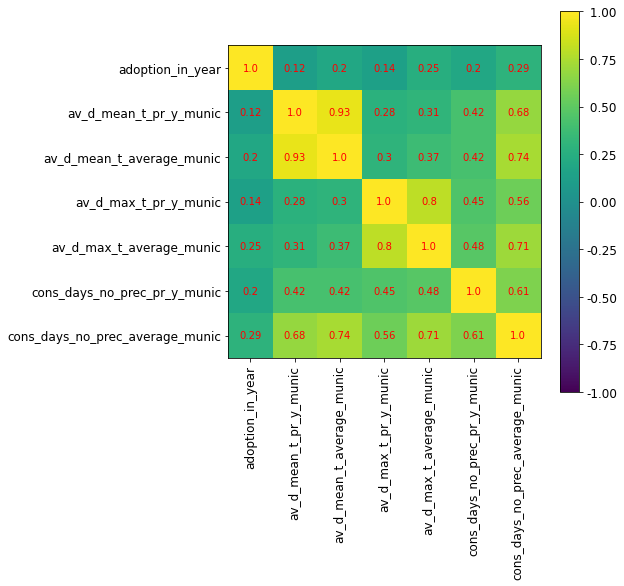

In [84]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features_kept, label + climate_features_kept], size=(7, 7))

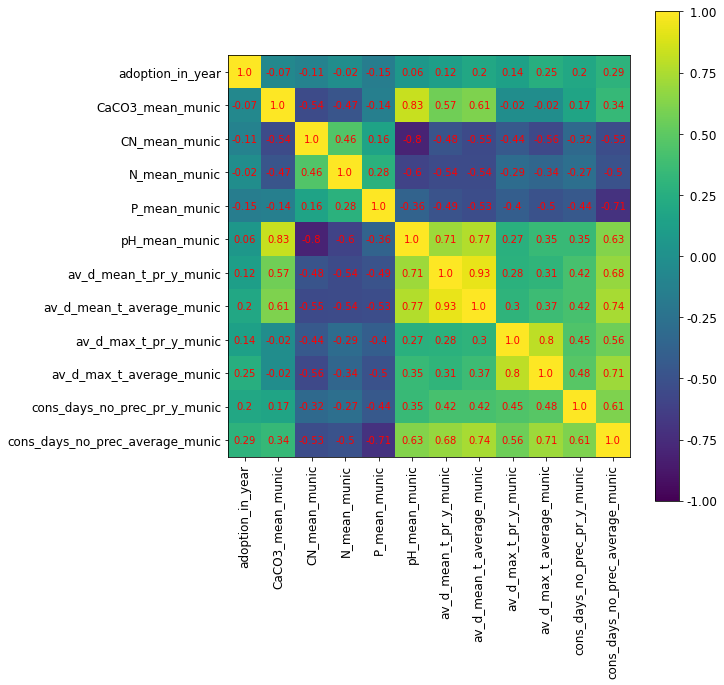

In [85]:
feats = label + soil_features + climate_features_kept
plot_correlation_heatmap(corr_matrix.loc[feats, feats], size=(9, 9))

In [86]:
spearman_results_both.loc[soil_features]

,spearman r only PCF,spearman r
CaCO3_mean_munic,0.004,-0.074
CN_mean_munic,-0.490,-0.110
N_mean_munic,-0.215,-0.020
P_mean_munic,-0.311,-0.155
pH_mean_munic,0.316,0.060


In [87]:
class TransformSoilFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        soil_features = X.columns

        # 'pH_mean_munic' excluded since high correlation with NC and CaCO3 (also with av_d_mean_t_average_munic)
        
        # Definition of the ones to keep. 
        feats_to_keep = [feat for feat in soil_features if feat != 'pH_mean_munic']

        return X[feats_to_keep]

### Economic features
The only one, the payments, was removed from the classification dataset for its unrealistic negative correlation due to the disaggregation.

### Create of a dataset with these transformations

In [105]:
# Get features names
feat_lists = [census_features, adoption_features, climate_features, soil_features]
transformers = [TransformCensusFeatures(), TransformAdoptionFeatures(), TransformClimateFeatures(), TransformSoilFeatures()]

features_red = []
for f, t in zip(feat_lists, transformers):
    features = t.transform(dataset[f]).columns.to_list()
    features_red = features_red + features

In [106]:
len(features_red)

18

In [107]:
from sklearn.compose import ColumnTransformer

full_dataset_transformation = ColumnTransformer([
    ('census', TransformCensusFeatures(), census_features),
    ('adoption', TransformAdoptionFeatures(), adoption_features),
    ('climate', TransformClimateFeatures(), climate_features),
    ('soil', TransformSoilFeatures(), soil_features)
    #('economic', TransformEconomicFeatures(), economic_features)
],
    remainder='drop')

In [108]:
dataset_attr_red = full_dataset_transformation.fit_transform(dataset)
dataset_attr_red = pd.DataFrame(dataset_attr_red, columns=features_red)
dataset_attr_red.insert(0, 'adoption_in_year', dataset[label].values)

In [109]:
dataset_attr_red

,adoption_in_year,pastures_area_var,pastures_area_mean,educ_second_super,farmers_over65,inc_mainly_ext,educ_none,work_unit_100ha,agric_area_owned,lu_per_agric_area,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,av_d_mean_t_average_munic,av_d_max_t_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic
0,0,0.398,0.508,1.572,0.238,0.339,36.832,94.740,0.608,1.982,0.000,0.000,14.265,34.167,49.111,10.764,17.127,2.340,17.505
1,1,0.426,0.569,1.639,0.242,0.349,35.149,92.080,0.613,1.974,0.000,0.001,14.265,34.167,49.111,10.764,17.127,2.340,17.505
2,1,0.455,0.635,1.706,0.247,0.359,33.466,89.420,0.617,1.966,0.001,0.002,14.265,34.167,49.111,10.764,17.127,2.340,17.505
3,0,0.483,0.708,1.773,0.252,0.369,31.783,86.760,0.622,1.958,0.002,0.004,14.265,34.167,49.111,10.764,17.127,2.340,17.505
4,1,0.512,0.789,1.840,0.258,0.380,30.100,84.100,0.627,1.950,0.002,0.007,14.265,34.167,49.111,10.764,17.127,2.340,17.505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,1,1.759,0.900,11.844,0.574,0.637,27.752,10.660,0.827,0.184,0.042,0.045,17.892,67.464,89.742,85.304,10.851,1.454,14.671
4694,0,1.379,0.735,12.682,0.580,0.684,26.036,10.930,0.834,0.177,0.043,0.048,17.892,67.464,89.742,85.304,10.851,1.454,14.671
4695,0,1.000,0.555,13.520,0.586,0.737,24.320,11.200,0.843,0.170,0.043,0.056,17.892,67.464,89.742,85.304,10.851,1.454,14.671
4696,0,0.900,0.506,14.358,0.593,0.787,22.604,12.010,0.846,0.160,0.043,0.065,17.892,67.464,89.742,85.304,10.851,1.454,14.671


### Reassess VIF

In [110]:
vif_attr_red = calculate_vif(dataset_attr_red)

In [111]:
vif_attr_red.sort_values('VIF', ascending=False)

,VIF
features,
Intercept,1315.493
CN_mean_munic,6.495
av_d_max_t_average_munic,6.009
cons_days_no_prec_average_munic,5.696
av_d_mean_t_average_munic,4.578
work_unit_100ha,4.571
CaCO3_mean_munic,3.678
inc_mainly_ext,3.663
educ_second_super,2.892


## Metrics for final set of features

In [112]:
d = pd.DataFrame(index=features_red)

In [113]:
d['VIF'] = vif_attr_red

In [114]:
dataset_attr_red_PCF = pd.DataFrame(dataset_attr_red.values, index=dataset_original.index,
                                        columns=dataset_attr_red.columns).loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [115]:
d2 = get_spearman_both(features_red, dataset_attr_red, dataset_attr_red_PCF)

In [116]:
d3 = pd.concat([d2, d], axis=1)

In [117]:
d3

,spearman r only PCF,spearman r,VIF
pastures_area_var,0.059,-0.133,1.041
pastures_area_mean,0.608,0.187,2.363
educ_second_super,0.451,-0.010,2.892
farmers_over65,0.035,-0.119,2.872
inc_mainly_ext,-0.509,-0.219,3.663
educ_none,-0.071,0.141,2.762
work_unit_100ha,-0.612,-0.137,4.571
agric_area_owned,-0.278,-0.059,1.646
lu_per_agric_area,-0.280,-0.067,1.555
tot_cumul_adoption_pr_y_munic,0.427,0.492,1.121
